# Test 2
------

An **Autoencoder** is a type of neural network that can be used to **learn the representation of data.**
Autoencoders are generally implemented **unsupervised learning** algorithms that learn the representation of data without being provided with labels. **Convolutional Autoencoders** employ convolutional proccessing of data.

An autoencoder generally consists to two main parts:
<img src="autoencoder.jpg">
1. Encoder - Part of network that learns to reduce the input dimensions and compress the data into an encoded form
2. Decoder - Part of network that learns to reconstruct data from the encoded form

Generally, the reconstructed input/data is not perfect and hence lossy. This fact can we used to **detect anomalies**. When data, that is _different_ from the data the autoencoder learned to reconstruct, is passed through the network, the loss is quite high. _Normal_ data produces much lesser loss.  

Convolutional Autoencoder is the perfect candidate algorithms for the task of learning the representation of _Strong Gravitational Lensing Images_ and then using the learned represenatation to _detect anomalies_.

**A PyTorch implementation of Convolutional Autoencoders follows.**

# 1. Importing required python modules

In [0]:
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 2. Loading dataset
note: The given dataset was split into train (80%) and test (10%) folders and stored in a directory names 'data'

In [0]:
# dataset root directory
data_dir = './data'

# path to test and train directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# transforms to be applied on each image while loading
transform = transforms.Compose([transforms.Resize((112, 112)),
                                transforms.ToTensor()])

# Load images
train_data = datasets.ImageFolder(train_dir, transform = transform)
test_data = datasets.ImageFolder(test_dir, transform = transform)

#Defining dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

# 3. Defining the Convolutional Autoencoder network

In [0]:
class Autoencoder(nn.Module):
    '''
        Autoencoder Class
        -------------------------
        Learns representation of images by encoding and then decoding them.

        input: Images of type:torch.Tensor and 
               shape:[batch(b), channels(c) = 3, image_height(h), image_width(w)]
        output: Decoded images of type:torch.Tensor and 
                shape:[batch(b), channels(c) = 3, image_height(h), image_width(w)]
    '''

    def __init__(self):
        '''
            Function to initialize Autoencoder class object
        '''

        super(Autoencoder, self).__init__()

        # Encoder half of network
        self.encoder = nn.Sequential(
            # [b, 3, h, w] --> [b, 16, h, w]
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7,
                      stride = 3, padding = 1),
            nn.ReLU(),
            # [b, 16, h, w] --> [b, 32, h, w]
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 7,
                      stride = 3, padding = 1),
            nn.ReLU(),
            # [b, 32, h, w] --> [b, 64, h, w]
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 7)
        )

        # decoder half of network
        self.decoder = nn.Sequential(
            # [b, 64, h, w] --> [b, 32, h, w]
            nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 7),
            nn.ReLU(),
            # [b, 32, h, w] --> [b, 16, h, w]
            nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 7,
                               stride = 3, padding = 1, output_padding = 1),
            nn.ReLU(),
            # [b, 16, h, w] --> [b, 3, h, w]
            nn.ConvTranspose2d(in_channels = 16, out_channels = 3, kernel_size = 7,
                               stride = 3, padding = 1, output_padding = 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        '''
            Function that performs forward pass through network
            -------------------------------------------------------
            Performs forward pass through the network

            input: Images of type:torch.Tensor and 
                   shape:[batch(b), channels(c) = 3, image_height(h), image_width(w)]
            returns: Decoded images of type:torch.Tensor and 
                   shape:[batch(b), channels(c) = 3, image_height(h), image_width(w)]
        '''
        
        # pass input through encoder
        encoded = self.encoder(x)
        # pass encoded image through decoder
        decoded = self.decoder(encoded)
        # return decoded image
        return decoded

# 4. Training function

In [0]:
def train(model, device, optimizer, criterion, train_loader, num_epochs=5):
    '''
        Function to train model on training dataset
        --------------------------------------------------------
        inputs: model -> model to train
                device -> device to train model on (cpu/gpu)
                optimizer -> OptimizerClass() object that adjusts model weight
                criterion -> LossClass() object that determines model performence
                train_loader -> DataLoader object that contains training data
                num_epochs -> number of epochs to train model for
        
        outputs: losses -> list of tuples of the form (epoch, input_images, output_images)
                           epoch -> training epoch
                           input_images -> images into the model
                           output_images -> images produced by model
    '''
    print("Training...")
    
    results = []
    for epoch in range(num_epochs):
        # image label is not required for unsuprvised learning
        for images, _ in train_loader:
            # move image to training device
            images = images.to(device)

            # pass images through model network and determine loss
            outputs = model(images)
            loss = criterion(outputs, images)

            # adjust model network weights to reduce loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # print training logs
        print('Epoch:{} | Training loss:{:.4f}'.format(epoch+1, float(loss)))
        #store results
        results.append((epoch, images, outputs),)
    return results

# 5. Test function

In [0]:
def test(model, device, test_loader):
    '''
        Function to test trained model on testing dataset
        --------------------------------------------------------
        inputs: model -> model to test
                test_loader -> DataLoader object that contains testing data
        
        outputs: losses -> list of loss on each image
    '''

    # put model into evaluation mode
    model.eval()
    losses = []

    for images,_ in test_loader:
       images = images.to(device)
       output = model(images)
       # Compute Mean Square Error Loss between input image and produced output image
       loss = nn.MSELoss()(output, images)
       # store loss
       losses.append(loss.item())
    return losses

# 6. Utility functions

In [0]:
def save_model(model, optimizer, save_path):
    '''
     Function to save trained model
     -------------------------------------
     inputs: model -> model to save
             optimizer -> optimizer associated with model to be saved
             save_path -> path to where model is to be stored
    '''

    torch.save({
        'model': model.state_dict(), 
        'optimizer' : optimizer.state_dict(),
        }, save_path)
    
    
def load_model(save_path):
    '''
      Function to load saved model
      -------------------------------------
      inputs: save_path -> path to location where model was saved

      outputs: dictionary of the form {'model' : model, 'optimizer' : optimizer}
               model -> loaded model of type ModelClass()
               optimizer -> loaded optimizer of type OptimizerClass()
    '''

    return torch.load(save_path)


def display_training_results(results, num_epochs, print_every):
    '''
        Function to display results while training
        ----------------------------------------------
        inputs: results -> list of tuples of the form (epoch, input_images, output_images)
                num_epochs -> number of epochs to consider
                print_every -> number of epochs to skip between each displayed result
    '''

    for epoch in range(0, num_epochs, print_every):
        fig = plt.figure(figsize=(14, 3))
        fig.suptitle(f"Epoch: {epoch}")

        # get input images of current epoch
        input = results[epoch][1].detach().cpu().numpy()
        # get output images of current epoch
        output = results[epoch][2].detach().cpu().numpy()

        # display some input images
        for i, item in enumerate(input):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            plt.imshow(item[0], cmap='gray', aspect='auto')
        # display corresponding output images
        for i, item in enumerate(output):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1)
            plt.imshow(item[0], cmap='gray', aspect='auto')


def display_test_results(losses):
    '''
        Function to display test results
        -------------------------------------
        input -> list of losses for each image in test dataset
    '''

    # plot density function
    sns.kdeplot(losses, shade = True).set_title("Loss Distribution")
    # add rug plot
    sns.rugplot(losses)
    plt.show()

# 7. Defining hyper-parameters and training model

Training...
Epoch:1 | Training loss:0.0080
Epoch:2 | Training loss:0.0081
Epoch:3 | Training loss:0.0082
Epoch:4 | Training loss:0.0082
Epoch:5 | Training loss:0.0080
Epoch:6 | Training loss:0.0076
Epoch:7 | Training loss:0.0077
Epoch:8 | Training loss:0.0078
Epoch:9 | Training loss:0.0077
Epoch:10 | Training loss:0.0077
Epoch:11 | Training loss:0.0074
Epoch:12 | Training loss:0.0076
Epoch:13 | Training loss:0.0072
Epoch:14 | Training loss:0.0066
Epoch:15 | Training loss:0.0070
Epoch:16 | Training loss:0.0065
Epoch:17 | Training loss:0.0066
Epoch:18 | Training loss:0.0063
Epoch:19 | Training loss:0.0067
Epoch:20 | Training loss:0.0063
Epoch:21 | Training loss:0.0065
Epoch:22 | Training loss:0.0060
Epoch:23 | Training loss:0.0058
Epoch:24 | Training loss:0.0056
Epoch:25 | Training loss:0.0055
Epoch:26 | Training loss:0.0055
Epoch:27 | Training loss:0.0056
Epoch:28 | Training loss:0.0052
Epoch:29 | Training loss:0.0056
Epoch:30 | Training loss:0.0054
Epoch:31 | Training loss:0.0028
Epoch

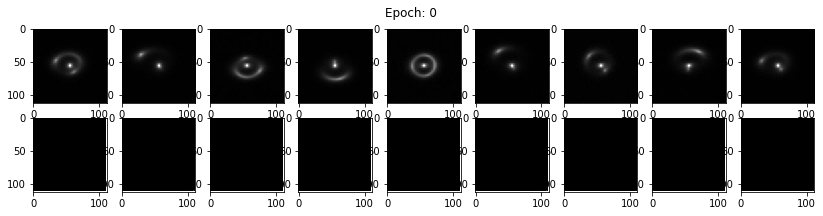

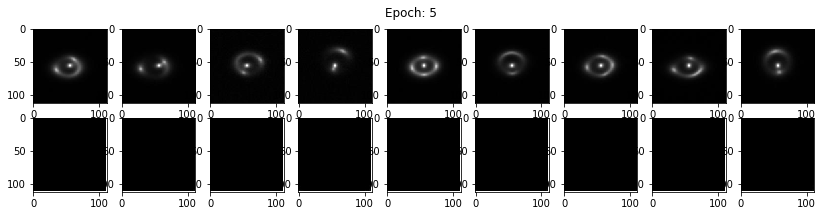

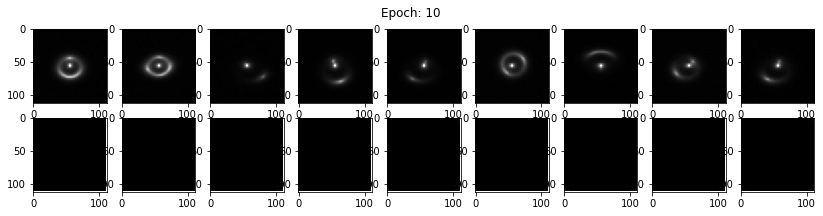

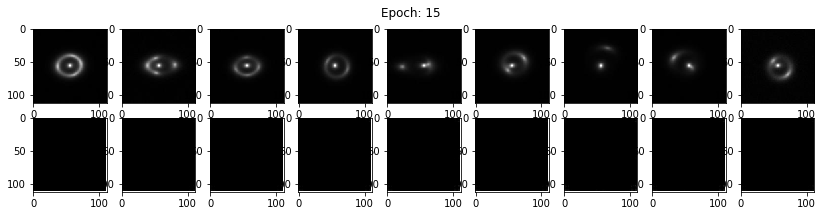

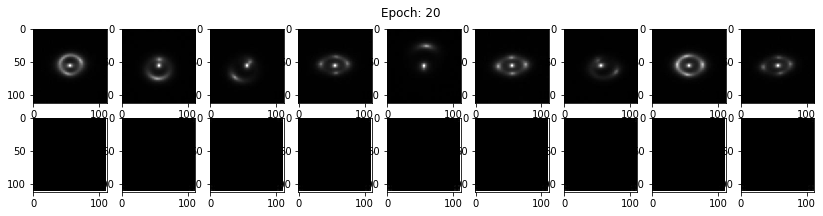

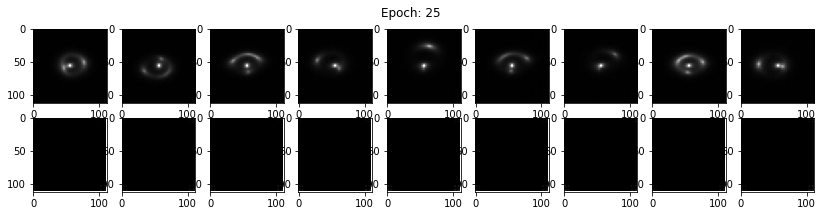

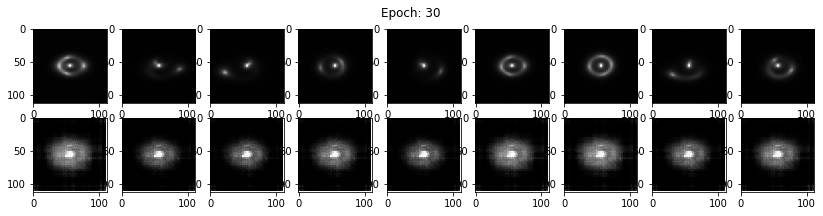

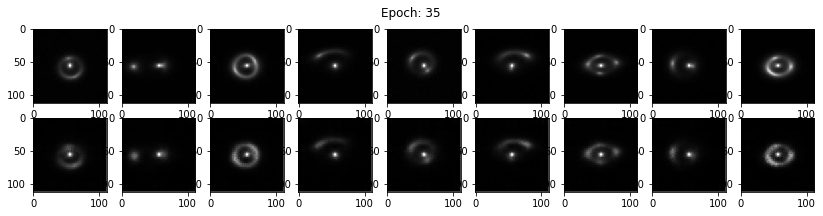

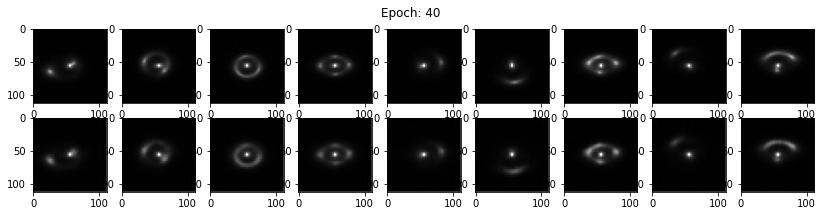

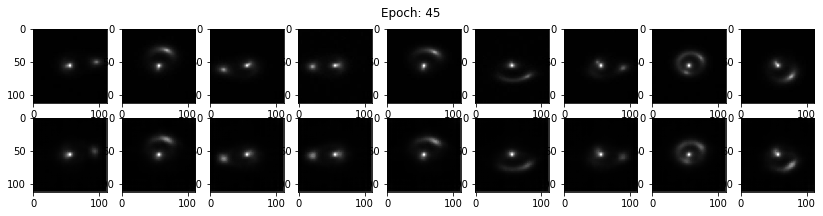

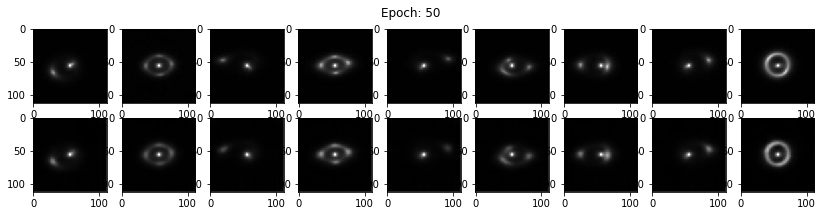

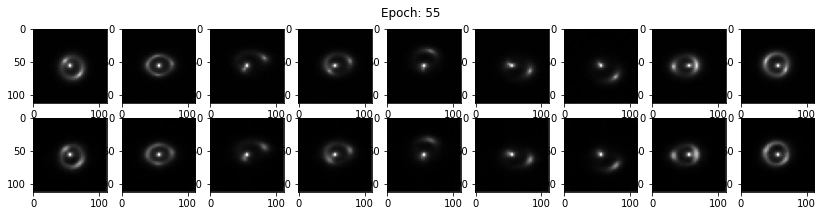

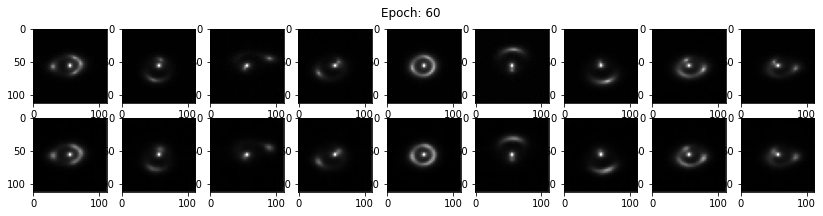

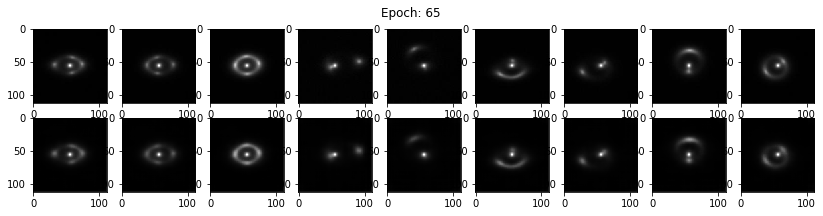

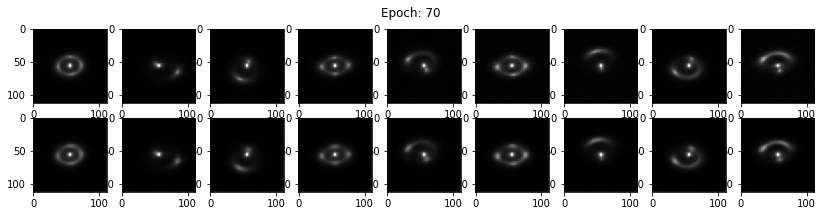

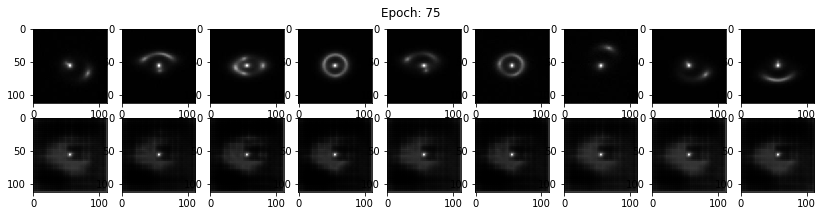

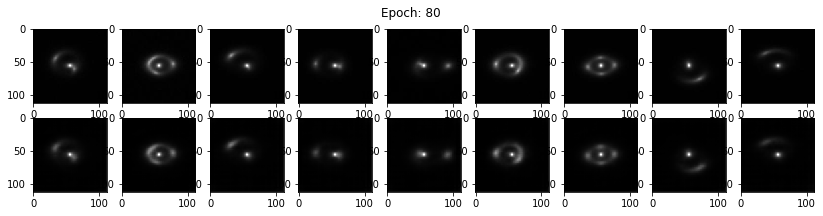

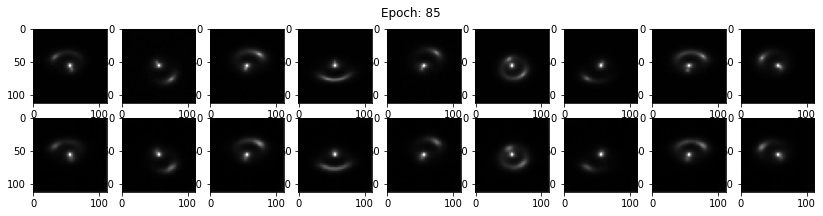

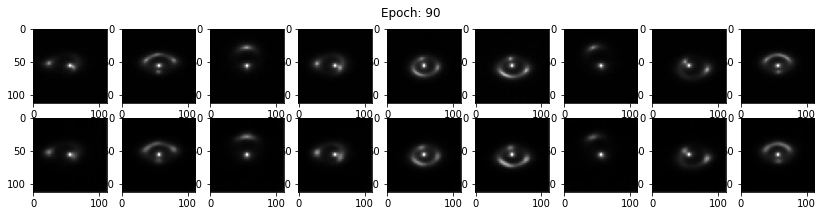

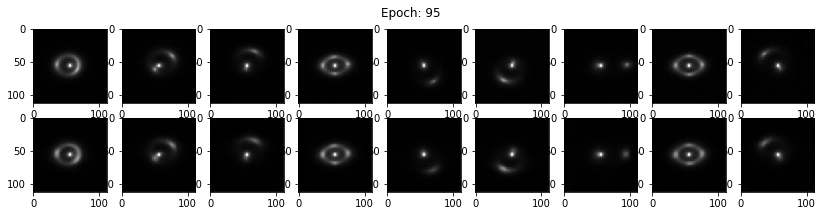

In [7]:
# Defining hyper-parameters for new model
num_epochs = 100
learning_rate = 1e-3

# set device to GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Autoencoder()
# move model to GPU if available
if torch.cuda.is_available():
    model.cuda()

# Define optimizer and criterion 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
criterion = nn.MSELoss()

# Train model
results = train(model, device, optimizer, criterion, train_loader, num_epochs = num_epochs)

# Display training results
display_training_results(results, num_epochs, 5)

# change save path to where you want to save model
save_path = "./gravitational_lensing_autoencoder_model.pkl"
# Save model
save_model(model, optimizer, save_path)

# 8. Testing trained model

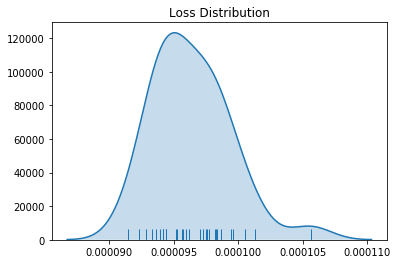

Test Loss: 0.0001


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# test trained model
losses = test(model, device, test_loader)

# display test results
display_test_results(losses)

# calculate and print average loss
avg_loss = sum(losses)/len(losses)
print("Test Loss: {:.4f}".format(avg_loss))

# 9. Anomaly detection

The model built above has learnt to reconstruct _Strong Gravitational Lensing by Dark Matter simulation images_ very well, but only such images. Irrespective of wether the images have substructure or not, the model is able to reconstruct them without any loss. However, when it is used to reconstruct any other type of images, the loss will be significantly higher. This fact is the crux of anomaly detection with autoencoders. 
As can be seenin the graph above, the loss is distributed almost normally. So any loss value that is more than 2 times the standard deviation can be considered an anomaly. This can be used to detect novel images that may need more attention or to remove faulty images.